In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.plotting import lag_plot
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

<ipython-input-2-b29455bf513e>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


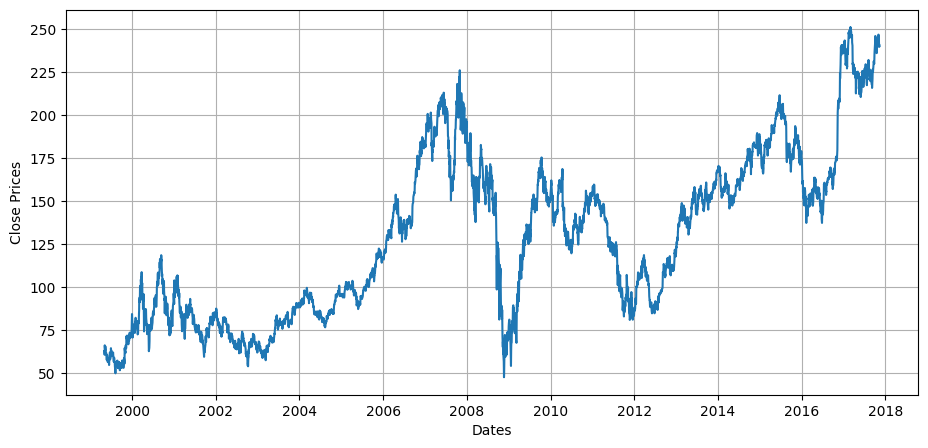

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('gs.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
plt.figure(figsize=(11,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])

In [3]:
data.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1999-05-04,67.665,68.780,62.329,62.659,24472946,0
1999-05-05,62.213,62.213,58.991,61.547,8295140,0
1999-05-06,60.542,61.773,59.712,60.488,3185852,0
1999-05-07,60.488,66.671,59.429,65.998,5331091,0
1999-05-10,65.331,65.441,62.549,62.941,2839054,0


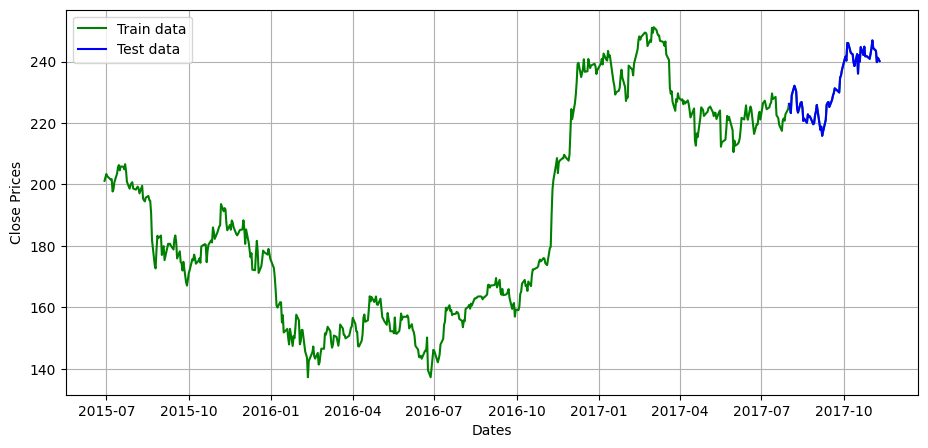

In [4]:
train_data, test_data = data[0:-73], data[-73:]
plt.figure(figsize=(11,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'].tail(600), 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.legend()

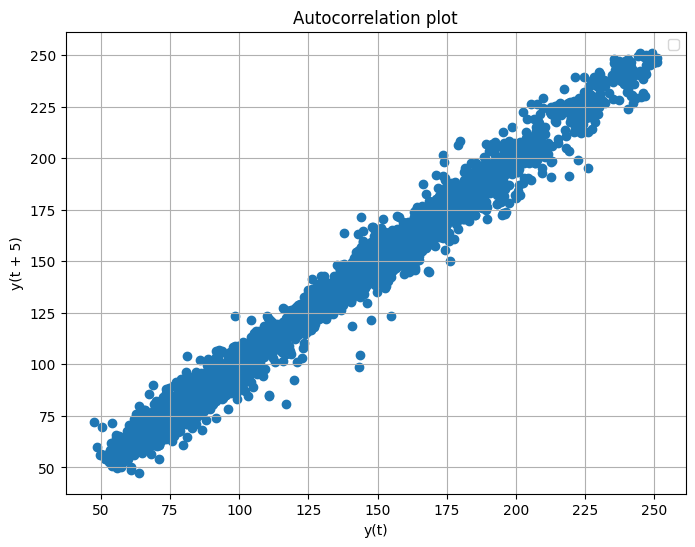

In [5]:
plt.figure(figsize=(8,6))
lag_plot(data['Close'], lag=5)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend()

In [6]:
values = DataFrame(data['Close'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.994090  0.987943  0.956348  0.998389
t+1   0.994090  1.000000  0.992704  0.963235  0.992745
t+5   0.987943  0.992704  1.000000  0.971587  0.986674
t+10  0.956348  0.963235  0.971587  1.000000  0.954596
t+30  0.998389  0.992745  0.986674  0.954596  1.000000


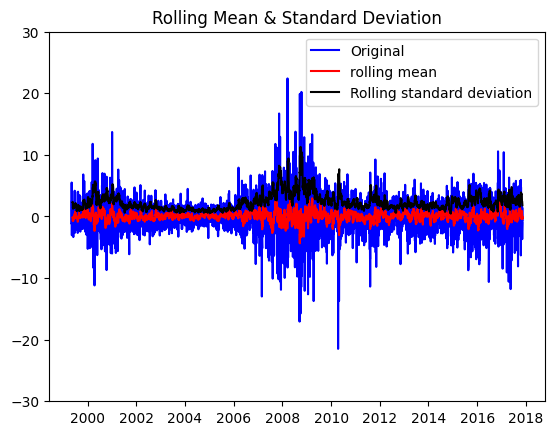

Results of Dickey-Fuller Test:
Test Statistic                -1.518009e+01
p-value                        6.215063e-28
#Lags Used                     1.600000e+01
Number of Observations Used    4.643000e+03
Critical value (1%)           -3.431759e+00
Critical value (5%)           -2.862163e+00
Critical value (10%)          -2.567101e+00
dtype: float64


In [7]:
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim([-30,30])
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
ts_log = data['Close']
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

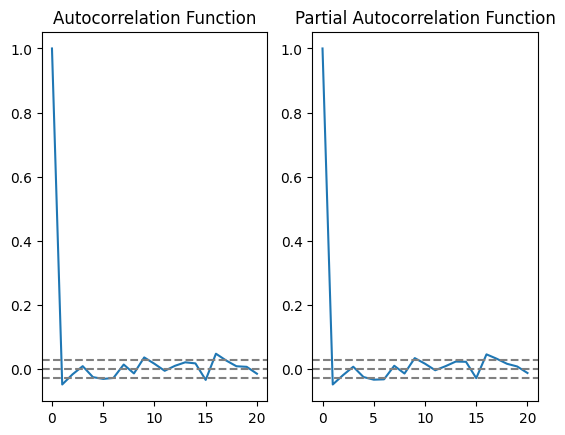

In [8]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

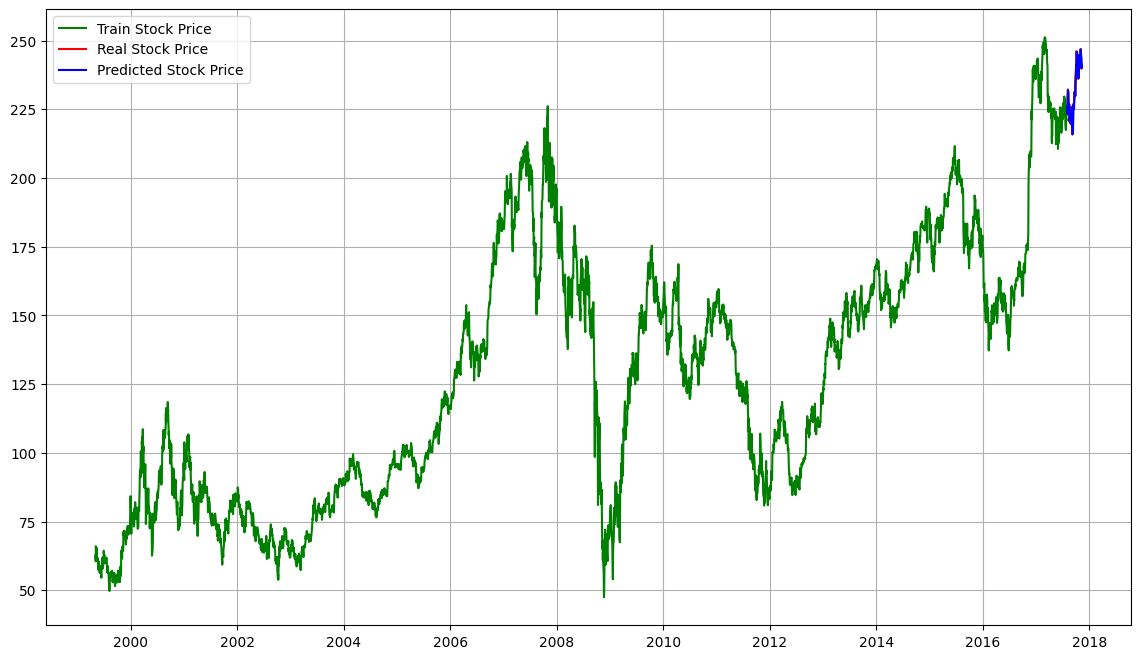

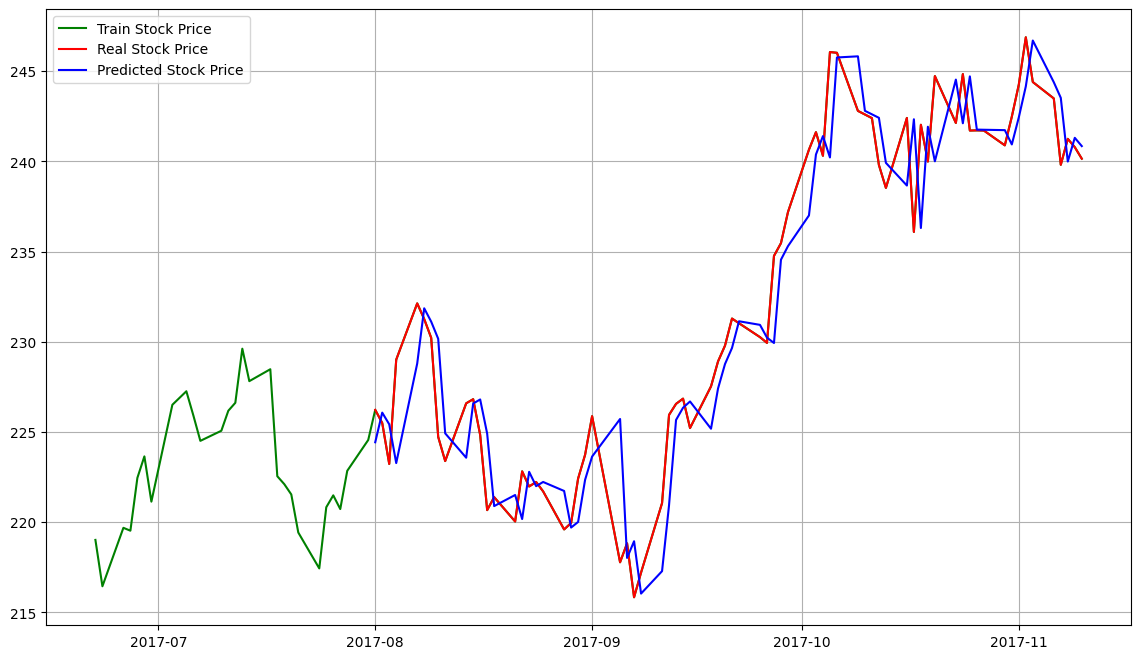

MSE: 7.388816706822366
MAE: 2.088423499431387
RMSE: 2.718237794384878


In [9]:
train_arma = train_data['Close']
test_arma = test_data['Close']
history = [x for x in train_arma]
y = test_arma
predictions = list()
model = ARIMA(history, order=(1,1,1))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
for i in range(1, len(y)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = y[i]
    history.append(obs)
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Close'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

<Figure size 1850x1050 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

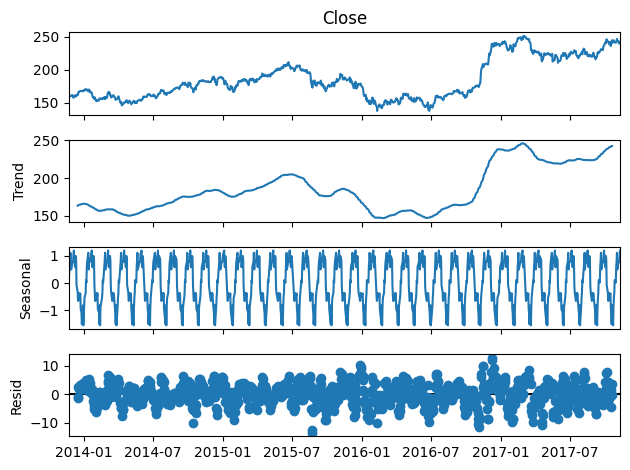

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
data_arima = data['Close']
fig = plt.figure()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
decomposition = seasonal_decompose(data_arima[-1000:], model='additive', period=30)
plt.figure(figsize=(20,10))
fig = decomposition.plot()
plt.show()

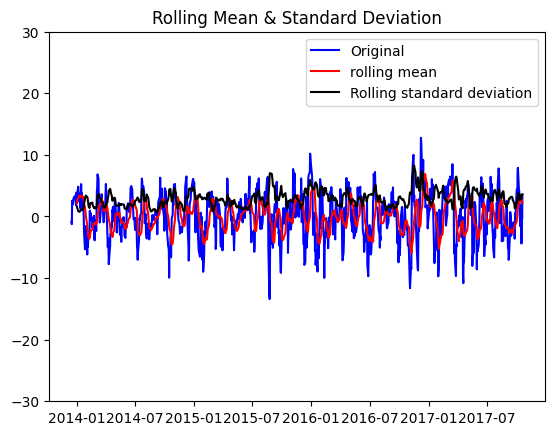

Results of Dickey-Fuller Test:
Test Statistic                -1.129182e+01
p-value                        1.373856e-20
#Lags Used                     8.000000e+00
Number of Observations Used    9.610000e+02
Critical value (1%)           -3.437173e+00
Critical value (5%)           -2.864552e+00
Critical value (10%)          -2.568374e+00
dtype: float64


In [44]:
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim([-30,30])
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
residual = decomposition.resid
residual.dropna(inplace=True)
test_stationarity(residual)

In [45]:
trend = decomposition.trend
sea=decomposition.seasonal

In [46]:
train_trend, test_trend = trend[0:-73], trend[-73:]
train_sea, test_sea = sea[0:-73], sea[-73:]

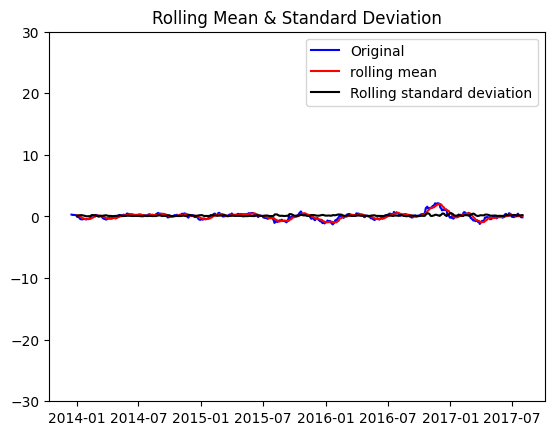

Results of Dickey-Fuller Test:
Test Statistic                  -4.876037
p-value                          0.000039
#Lags Used                      19.000000
Number of Observations Used    891.000000
Critical value (1%)             -3.437711
Critical value (5%)             -2.864789
Critical value (10%)            -2.568500
dtype: float64


In [48]:
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim([-30,30])
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
ts_log = train_trend
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

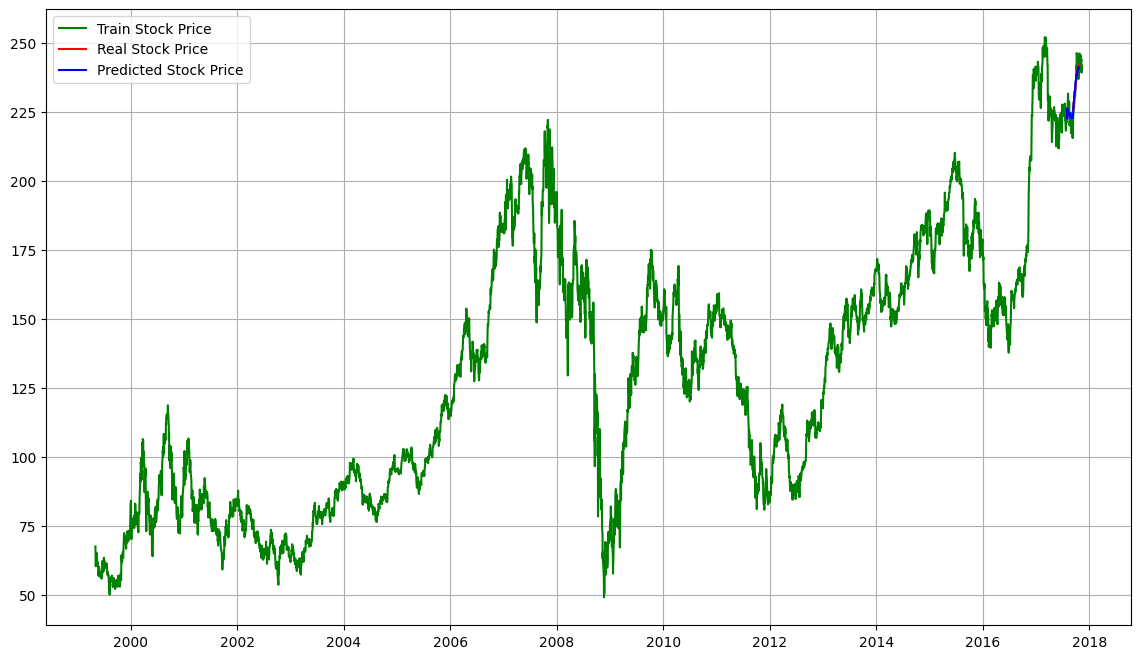

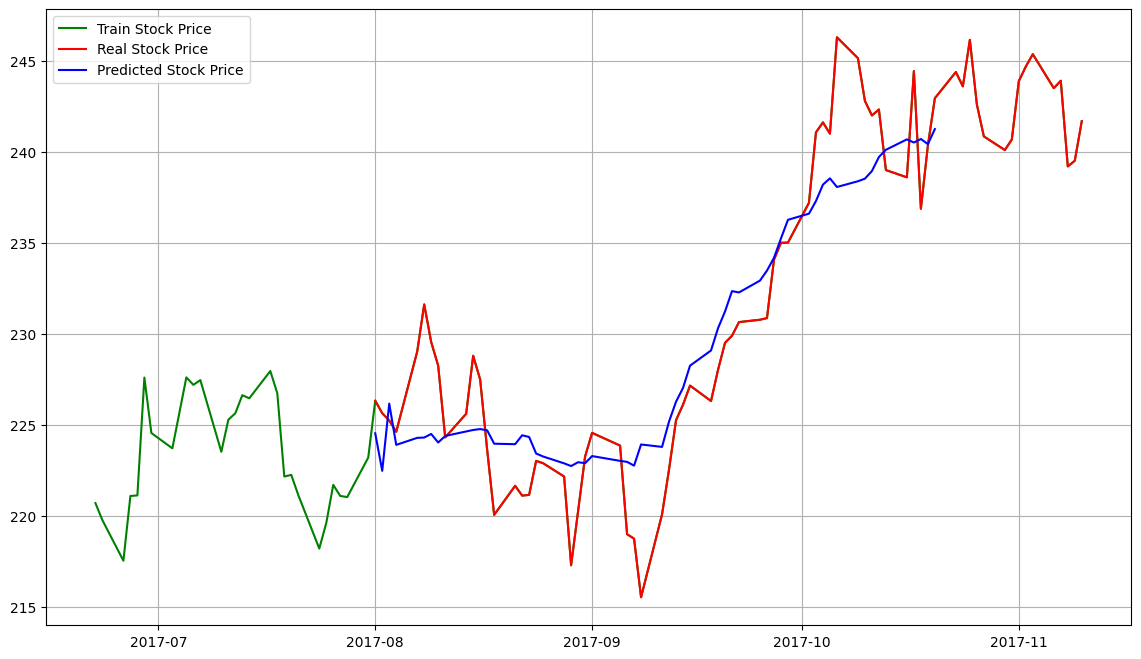

MSE: 0.7335365638829764
MAE: 0.7440541220749168
RMSE: 0.8564674914338409


In [50]:
train_arima = train_trend.dropna()
test_arima = test_trend.dropna()
history = [x for x in train_arima]
y = test_arima
predictions = list()
model = ARIMA(history, order=(2,1,2))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0]+test_sea[0])
for i in range(1, len(y)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat+test_sea[i])
    obs = y[i]
    history.append(obs)
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Open'], color='green', label = 'Train Stock Price')
plt.plot(y.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(y.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(data.index[-73:], data['Open'].tail(73), color = 'red', label = 'Real Stock Price')
plt.plot(y.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

In [26]:
df = data[['Close']]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4661 entries, 1999-05-04 to 2017-11-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4661 non-null   float64
dtypes: float64(1)
memory usage: 72.8 KB


In [27]:
df=df.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))


In [28]:
def load_data(stock, look_back):
    data_raw = stock.values
    data = []

    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

look_back = 60
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3681, 59, 1)
y_train.shape =  (3681, 1)
x_test.shape =  (920, 59, 1)
y_test.shape =  (920, 1)


In [29]:

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


In [30]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1



class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()


        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [31]:
num_epochs = 100
hist = np.zeros(num_epochs)

seq_dim =look_back-1

for t in range(num_epochs):


    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)

    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  0 MSE:  0.2595527470111847
Epoch  1 MSE:  0.1755339652299881
Epoch  2 MSE:  0.13418304920196533
Epoch  3 MSE:  0.15879419445991516
Epoch  4 MSE:  0.11858020722866058
Epoch  5 MSE:  0.09987461566925049
Epoch  6 MSE:  0.09240677952766418
Epoch  7 MSE:  0.07679090648889542
Epoch  8 MSE:  0.04117480292916298
Epoch  9 MSE:  0.05801272392272949
Epoch  10 MSE:  0.01590721122920513
Epoch  11 MSE:  0.019954435527324677
Epoch  12 MSE:  0.0271743256598711
Epoch  13 MSE:  0.018623536452651024
Epoch  14 MSE:  0.008960975334048271
Epoch  15 MSE:  0.010456007905304432
Epoch  16 MSE:  0.013880807906389236
Epoch  17 MSE:  0.010999582707881927
Epoch  18 MSE:  0.00715248379856348
Epoch  19 MSE:  0.006902170833200216
Epoch  20 MSE:  0.008892623707652092
Epoch  21 MSE:  0.010415181517601013
Epoch  22 MSE:  0.01029386930167675
Epoch  23 MSE:  0.008899383246898651
Epoch  24 MSE:  0.007088438142091036
Epoch  25 MSE:  0.0058013442903757095
Epoch  26 MSE:  0.005772972479462624
Epoch  27 MSE:  0.006368665

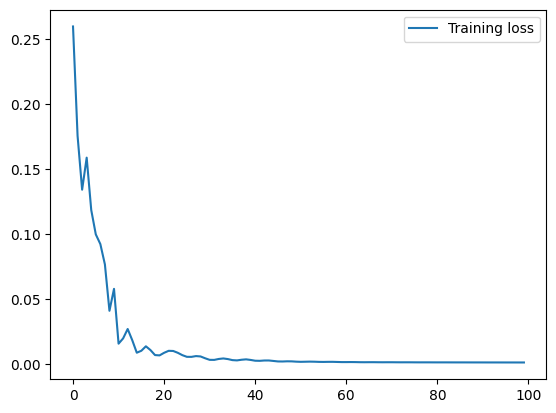

In [32]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [33]:
import math
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.89 RMSE
Test Score: 4.39 RMSE


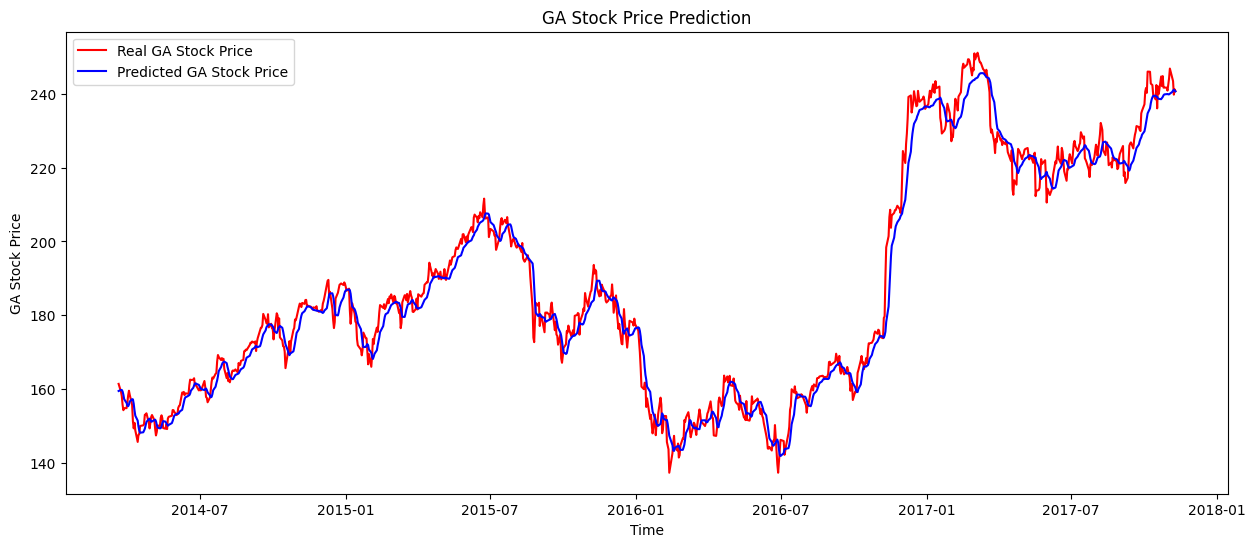

In [36]:
import numpy as np


#y_test_pred = y_test_pred.detach().numpy()
fig, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color='red', label='Real GA Stock Price')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color='blue', label='Predicted GA Stock Price')

plt.title('GA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GA Stock Price')
plt.legend()
plt.show()


In [37]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_test_pred)
print("Mean absolute error on test set: ", mae)

Mean absolute error on test set:  3.3075402
